## Data Quality 

### Import Libraries 

In [71]:
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score
# import interpretability_module as interp
# from utils import *
import pandas as pd
import sys
import time

from sklearn.metrics import accuracy_score, r2_score, mean_absolute_error, confusion_matrix, f1_score, average_precision_score

In [72]:
telecom_data = pd.read_csv('../../../data/churn_examples/telecom_customer_churn.csv')

In [73]:
telecom_data['age'].value_counts()

KeyError: 'age'

In [ ]:
def rename_column_names(telecom_data):
    telecom_data.columns = map(str.lower, telecom_data.columns)
    telecom_data.columns =  telecom_data.columns.str.replace(' ', '_')
    return telecom_data

In [ ]:
telecom_data = rename_column_names(telecom_data)

In [ ]:
telecom_data.columns

Index(['customer_id', 'gender', 'age', 'married', 'number_of_dependents',
       'city', 'zip_code', 'latitude', 'longitude', 'number_of_referrals',
       'tenure_in_months', 'offer', 'phone_service',
       'avg_monthly_long_distance_charges', 'multiple_lines',
       'internet_service', 'internet_type', 'avg_monthly_gb_download',
       'online_security', 'online_backup', 'device_protection_plan',
       'premium_tech_support', 'streaming_tv', 'streaming_movies',
       'streaming_music', 'unlimited_data', 'contract', 'paperless_billing',
       'payment_method', 'monthly_charge', 'total_charges', 'total_refunds',
       'total_extra_data_charges', 'total_long_distance_charges',
       'total_revenue', 'customer_status', 'churn_category', 'churn_reason'],
      dtype='object')

In [ ]:
telecom_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 38 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   customer_id                        7043 non-null   object 
 1   gender                             7043 non-null   object 
 2   age                                7043 non-null   int64  
 3   married                            7043 non-null   object 
 4   number_of_dependents               7043 non-null   int64  
 5   city                               7043 non-null   object 
 6   zip_code                           7043 non-null   int64  
 7   latitude                           7043 non-null   float64
 8   longitude                          7043 non-null   float64
 9   number_of_referrals                7043 non-null   int64  
 10  tenure_in_months                   7043 non-null   int64  
 11  offer                              3166 non-null   objec

In [ ]:
telecom_data['customer_status'].value_counts()

customer_status
Stayed     4720
Churned    1869
Joined      454
Name: count, dtype: int64

### Binary Columns Filter 

In [ ]:
binary_columns = telecom_data.isin(['Yes', 'No']).all(axis=0)
binary_df = telecom_data.loc[:, binary_columns]

In [ ]:
telecom_data['online_security'].unique()

array(['No', 'Yes', nan], dtype=object)

In [26]:
telecom_data.fillna(-1,inplace=True)

In [27]:
telecom_data['gender'].replace(['Female', 'Male'],[0, 1], inplace=True)
telecom_data['married'].replace(['No', 'Yes'],[0, 1], inplace=True)
telecom_data['online_security'].replace(['No', 'Yes'],[0, 1], inplace=True)
telecom_data['online_backup'].replace(['No', 'Yes'],[0, 1], inplace=True)
telecom_data['internet_service'].replace(['No', 'Yes'],[0, 1], inplace=True)
telecom_data['phone_service'].replace(['No', 'Yes'],[0, 1], inplace=True)
telecom_data['multiple_lines'].replace(['No', 'Yes'],[0, 1], inplace=True)
telecom_data['device_protection_plan'].replace(['No', 'Yes'],[0, 1], inplace=True)
telecom_data['premium_tech_support'].replace(['No', 'Yes'],[0, 1], inplace=True)
telecom_data['offer'].replace(['None', '0','1','2','3','4'],[-1,0, 1,2,3,4], inplace=True)
telecom_data['payment_method'].replace(['Bank Withdrawal', 'Credit Card','Mailed Check'],[0, 1,2], inplace=True)

telecom_data['streaming_tv'].replace(['No', 'Yes'],[0, 1], inplace=True)
telecom_data['streaming_movies'].replace(['No', 'Yes'],[0, 1], inplace=True)
telecom_data['streaming_music'].replace(['No', 'Yes'],[0, 1], inplace=True)
telecom_data['paperless_billing'].replace(['No', 'Yes'],[0, 1], inplace=True)
telecom_data['unlimited_data'].replace(['No', 'Yes'],[0, 1], inplace=True)

telecom_data['contract'].replace(['Month-to-Month', 'Two Year','One Year'],[1, 2,3], inplace=True)

telecom_data['offer'].replace(['Offer A', 'Offer B','Offer C','Offer D','Offer E'],[0, 1,2,3,4], inplace=True)
telecom_data['internet_type'].replace(['Fiber Optic','DSL','Cable'],[1,2,3], inplace=True)
telecom_data['customer_status'].replace(['Stayed','Joined','Churned'],[0,2,1], inplace=True)


In [48]:
filtered_telecom_data = telecom_data[telecom_data['customer_status'].isin([0,1])]

In [57]:
# if __name__ == '__main__': # dask seems to need this
    # launch with "python plot_anomalies.py http.csv attack 20000 256 100 99"
    # or, "python plot_anomalies.py cancer.csv diagnosis all 5 1000 80
    
# for the random survival analysis data, try to use "python plot_anomalies.py survival.csv status(risk score) all 5 1000 80"
# datafile = df_data_set
# targetcol = score
sample_size = 5
n_trees = 1000
# desired_TPR = 80
# desired_TPR /= 100.0
# print("desired_tpr",desired_TPR)
val = 'all'

# df = pd.read_csv(datafile)

if val=='all':
    N = len(telecom_data)
    # print(N)
# else:
#     N = int(sys.argv[3])

df = filtered_telecom_data.sample(400)  # grab random subset (too slow otherwise)
# print(df.columns)

X, y = df[['gender','age','married','number_of_dependents','zip_code','number_of_referrals', 'tenure_in_months','offer','phone_service', 'streaming_tv','streaming_movies','streaming_music']], df['customer_status']
X['listindex'] = range(0, len(df))
# plot_anomalies(X, y, sample_size=sample_size, n_trees=n_trees, desired_TPR=desired_TPR, bins=15)

C:\Users\dumb_\AppData\Local\Temp\ipykernel_25052\1446908472.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['listindex'] = range(0, len(df))


In [58]:
to_model_columns=['gender','age','married','number_of_dependents','zip_code','number_of_referrals', 'tenure_in_months','streaming_tv','streaming_movies','streaming_music']

In [59]:
from sklearn.ensemble import IsolationForest
clf=IsolationForest(n_estimators=100, max_samples='auto', bootstrap=False,random_state=42, verbose=0)
clf.fit(X[to_model_columns])

IsolationForest(random_state=42)

In [60]:
pred = clf.predict(X[to_model_columns])

In [61]:
X['anomaly']=pred
normal=X.loc[X['anomaly']==1]
outliers=X.loc[X['anomaly']==-1]

normal_index=list(normal.listindex)
outlier_index=list(outliers.listindex)
print(outlier_index)
#Find the number of anomalies and normal points here points classified -1 are anomalous
print(X['anomaly'].value_counts())

[0, 2, 3, 5, 7, 8, 9, 10, 11, 12, 13, 17, 18, 20, 21, 22, 24, 25, 26, 27, 30, 32, 34, 35, 37, 38, 39, 40, 41, 42, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 58, 60, 62, 64, 65, 66, 69, 71, 72, 73, 74, 76, 77, 78, 83, 84, 85, 86, 88, 89, 92, 93, 94, 96, 97, 98, 99, 101, 102, 105, 106, 107, 110, 111, 113, 115, 118, 119, 120, 121, 122, 124, 126, 128, 130, 131, 134, 136, 137, 138, 140, 143, 144, 145, 148, 149, 151, 152, 153, 156, 158, 160, 162, 165, 166, 168, 169, 170, 171, 174, 175, 176, 177, 178, 179, 180, 185, 186, 187, 188, 189, 191, 192, 193, 194, 195, 197, 199, 201, 202, 203, 206, 208, 209, 210, 211, 212, 215, 216, 217, 218, 219, 220, 221, 223, 224, 228, 229, 230, 231, 232, 235, 236, 237, 238, 239, 240, 241, 243, 244, 246, 247, 249, 250, 252, 255, 257, 258, 259, 260, 262, 264, 265, 267, 268, 269, 271, 272, 273, 279, 280, 281, 282, 283, 284, 287, 288, 290, 291, 292, 294, 296, 298, 299, 300, 301, 304, 305, 306, 307, 308, 310, 312, 317, 318, 319, 322, 323, 324, 325, 326, 327, 328, 329,

C:\Users\dumb_\AppData\Local\Temp\ipykernel_25052\3192386561.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['anomaly']=pred


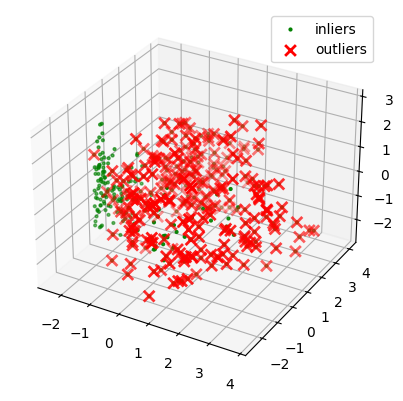

In [75]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
pca = PCA(n_components=3)  # Reduce to k=3 dimensions
scaler = StandardScaler()
#normalize the metrics
X_scalar = scaler.fit_transform(X[to_model_columns])
X_reduce = pca.fit_transform(X_scalar)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")

# Plot the compressed data points
ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=4, lw=1, label="inliers",c="green")

# Plot x's for the ground truth outliers
ax.scatter(X_reduce[outlier_index,0],X_reduce[outlier_index,1], X_reduce[outlier_index,2],
           lw=2, s=60, marker="x", c="red", label="outliers")
ax.legend()
plt.show()

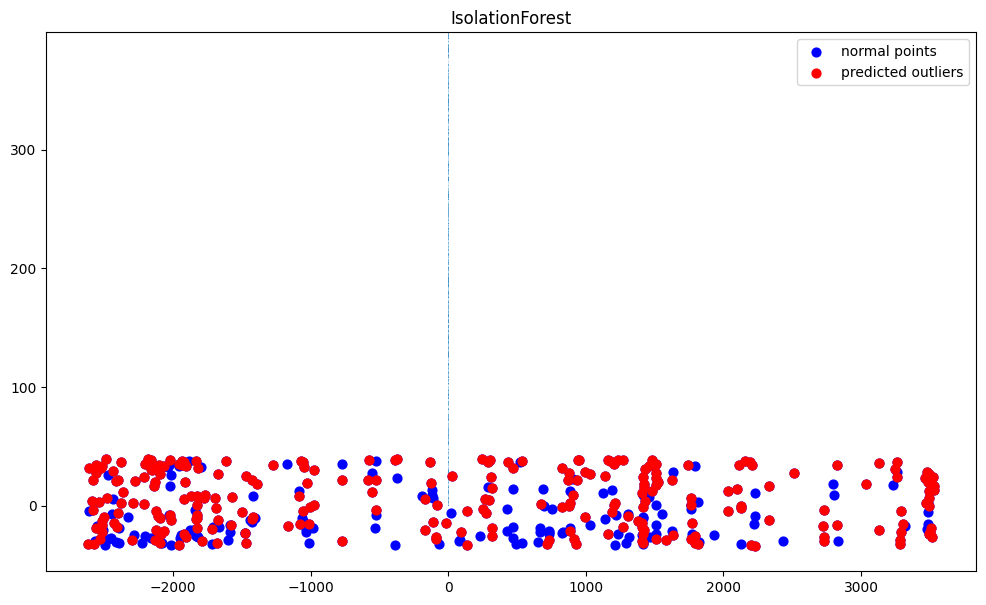

In [63]:
# from sklearn.decomposition import PCA
pca = PCA(2)
pca.fit(X[to_model_columns])


res=pd.DataFrame(pca.transform(X[to_model_columns]))

Z = np.array(res)
figsize=(12, 7)
plt.figure(figsize=figsize)
plt.title("IsolationForest")
plt.contourf( Z, cmap=plt.cm.Blues_r)

b1 = plt.scatter(res[0], res[1], c='blue',
                 s=40,label="normal points")

b1 = plt.scatter(res.iloc[outlier_index,0],res.iloc[outlier_index,1], c='red',
                 s=40,  edgecolor="red",label="predicted outliers")
plt.legend(loc="upper right")
plt.show()

In [64]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.plotly as py
import matplotlib.pyplot as plt
from matplotlib import pyplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
def plot_anomaly(df,metric_name):
    df.load_date = pd.to_datetime(df['load_date'].astype(str), format="%Y%m%d")
    dates = df.load_date
    #identify the anomaly points and create a array of its values for plot
    bool_array = (abs(df['anomaly']) > 0)
    actuals = df["actuals"][-len(bool_array):]
    anomaly_points = bool_array * actuals
    anomaly_points[anomaly_points == 0] = np.nan
    #A dictionary for conditional format table based on anomaly
    color_map = {0: "'rgba(228, 222, 249, 0.65)'", 1: "yellow", 2: "red"}
    
    #Table which includes Date,Actuals,Change occured from previous point
    table = go.Table(
        domain=dict(x=[0, 1],
                    y=[0, 0.3]),
        columnwidth=[1, 2],
        # columnorder=[0, 1, 2,],
        header=dict(height=20,
                    values=[['<b>Date</b>'], ['<b>Actual Values </b>'], ['<b>% Change </b>'],
                            ],
                    font=dict(color=['rgb(45, 45, 45)'] * 5, size=14),
                    fill=dict(color='#d562be')),
        cells=dict(values=[df.round(3)[k].tolist() for k in ['load_date', 'actuals', 'percentage_change']],
                   line=dict(color='#506784'),
                   align=['center'] * 5,
                   font=dict(color=['rgb(40, 40, 40)'] * 5, size=12),
                   # format = [None] + [",.4f"] + [',.4f'],
                   # suffix=[None] * 4,
                   suffix=[None] + [''] + [''] + ['%'] + [''],
                   height=27,
                   fill=dict(color=[test_df['anomaly_class'].map(color_map)],#map based on anomaly level from dictionary
                   )
                   ))
    #Plot the actuals points
    Actuals = go.Scatter(name='Actuals',
                         x=dates,
                         y=df['actuals'],
                         xaxis='x1', yaxis='y1',
                         mode='line',
                         marker=dict(size=12,
                                     line=dict(width=1),
                                     color="blue"))

    #Highlight the anomaly points
    anomalies_map = go.Scatter(name="Anomaly",
                               showlegend=True,
                               x=dates,
                               y=anomaly_points,
                               mode='markers',
                               xaxis='x1',
                               yaxis='y1',
                               marker=dict(color="red",
                                           size=11,
                                           line=dict(
                                               color="red",
                                               width=2)))


    axis = dict(
        showline=True,
        zeroline=False,
        showgrid=True,
        mirror=True,
        ticklen=4,
        gridcolor='#ffffff',
        tickfont=dict(size=10))

    layout = dict(
        width=1000,
        height=865,
        autosize=False,
        title=metric_name,
        margin=dict(t=75),
        showlegend=True,
        xaxis1=dict(axis, **dict(domain=[0, 1], anchor='y1', showticklabels=True)),
        yaxis1=dict(axis, **dict(domain=[2 * 0.21 + 0.20, 1], anchor='x1', hoverformat='.2f')))

    fig = go.Figure(data=[table, anomalies_map, Actuals], layout=layout)

    iplot(fig)
    pyplot.show()
    #return res

ModuleNotFoundError: No module named 'plotly'